In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
import joblib

from gensim.models.word2vec import Word2Vec
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

2025-05-20 09:47:40.921352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747734461.119685      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747734461.178585      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


The dataset has been previously labelled.

In [2]:
# Load the dataset from CSV file and show its head
df = pd.read_csv("/kaggle/input/vegan-20k/vegan_20k.csv", delimiter=";")
df

,ingredients,is_vegan
0,"[""1 cup shredded cheddar cheese"", ""1 cup chopp...",0
1,"[""1 pie crust"", ""1/2 lb. ground beef (you can ...",0
2,"[""2 small orange jello"", ""2 c. boiling water"",...",0
3,"[""12 (2 1/2-inch) square graham crackers, crum...",0
4,"[""1 (8 ounce.) pkg. cream cheese"", ""1 sm. jar ...",0
...,...,...
19995,"[""1 lb. hamburger, browned"", ""1 chopped onion""...",0
19996,"[""4 c. White Lily self-rising flour"", ""2 Tbsp....",0
19997,"[""1 c. mayonnaise"", ""1 tsp. onion, scraped"", ""...",0
19998,"[""1 1/2 c. sugar"", ""2 eggs"", ""2 c. Wesson oil""...",0


## Word2Vec Training

In [3]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Convert the 'ingredients' column to a list of lists
w2v_ingredients = df['ingredients'].apply(ast.literal_eval)

# Initialize an empty list to store the cleaned data
tokenized_ingredients = []

for ingredient_list in w2v_ingredients:
    cleaned_list = []
    
    for ingredient in ingredient_list:
        # Remove punctuation and convert to lowercase
        ingredient = re.sub(r'[^\w\s]', '', ingredient).lower()
        # Remove numbers and words nearby (e.g., '200g', '5ml', etc.)
        ingredient = re.sub(r'\b\d+(\w+)?\b', '', ingredient)
        
        # Tokenize
        tokens = ingredient.split()

         # Remove stopwords and single-character tokens
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

        # Add the cleaned tokens to the list
        cleaned_list.extend(tokens)

    # Append the cleaned list to the tokenized_ingredients list
    tokenized_ingredients.append(cleaned_list)

# Print a few samples to verify
print(tokenized_ingredients[:5])

[['cup', 'shredded', 'cheddar', 'cheese', 'cup', 'chopped', 'pimento', 'stuffed', 'olive', 'tablespoon', 'minced', 'onion', 'cup', 'dried', 'beef', 'chopped', 'cup', 'mayonnaise', 'loaf', 'sliced', 'rye', 'cocktail', 'bread'], ['pie', 'crust', 'lb', 'ground', 'beef', 'use', 'sausage', 'ham', 'bacon', 'mayonnaise', 'milk', 'eggs', 'tbsp', 'cornstarch', 'sliced', 'green', 'onions', 'grated', 'cheddar', 'cheese', 'diced', 'bell', 'pepper', 'tsp', 'salt', 'tsp', 'pepper'], ['small', 'orange', 'jello', 'boiling', 'water', 'small', 'crushed', 'pineapple', 'small', 'frozen', 'orange', 'juice', 'small', 'mandarin', 'oranges', 'pkg', 'instant', 'lemon', 'pudding', 'milk', 'pkg', 'dream', 'whip', 'prepared'], ['square', 'graham', 'crackers', 'crumbled', 'tbsp', 'reduced', 'calorie', 'margarine', 'melted', 'low', 'fat', 'cottage', 'cheese', 'pkg', 'sweetener', 'small', 'pkg', 'lemon', 'jello', 'sugar', 'free', 'boiling', 'water'], ['ounce', 'pkg', 'cream', 'cheese', 'sm', 'jar', 'old', 'english',

In [5]:
# Train the Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_ingredients, 
    vector_size=50, 
    window=10, 
    min_count=5, 
    sg=1,  # 1 for Skip-Gram, 0 for CBOW
    epochs=10
)

Now, we need to convert the ingredient lists into fixed-length vectors using the trained Word2Vec model. 

In [6]:
# Combine each ingredient list back into a single string for TF-IDF processing
corpus = [" ".join(ing) for ing in tokenized_ingredients]

# Compute TF-IDF matrix and dictionary
tfidf_vectorizer = TfidfVectorizer(min_df=5) # option to ignore rare terms that appear in less than 5 documents
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_dict = dict(zip(feature_names, tfidf_vectorizer.idf_))

In [7]:
def vectorize_ingredients_tfidf(ingredient_list, model, tfidf_dict):
    vectors = []
    weights = []
    
    for word in ingredient_list:
        if word in w2v_model.wv and word in tfidf_dict:
            # Get Word2Vec vector
            word_vec = model.wv[word]
            
            # Get TF-IDF weight
            weight = tfidf_dict[word]
            
            # Apply weighting
            vectors.append(word_vec * weight)
            weights.append(weight)
    
    # Handle cases with no matching words
    if len(vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    
    # Calculate weighted average
    return np.average(vectors, axis=0, weights=weights)

In [8]:
# Vectorize all samples using TF-IDF weighted Word2Vec
w2v_tfidf_vectors = np.array([vectorize_ingredients_tfidf(ing, w2v_model, tfidf_dict) for ing in tokenized_ingredients])

## Train a classifier

In [9]:
# Count the number of vegan and non-vegan samples
num_vegan = df[df['is_vegan'] == 1].shape[0]
num_non_vegan = df[df['is_vegan'] == 0].shape[0]

print(f"Number of vegan examples: {num_vegan}")
print(f"Number of non-vegan examples: {num_non_vegan}")

Number of vegan examples: 2176
Number of non-vegan examples: 17824


As we can see the dataset is highly unbalanced (as expected).

In [10]:
# 80/20 split for training and testing
y = df['is_vegan'].values
X_train, X_test, y_train, y_test = train_test_split(w2v_tfidf_vectors, y, test_size=0.2, random_state=42)

# Check class distribution in train and test sets
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Class distribution in training set: [14243  1757]
Class distribution in test set: [3581  419]


### Logistic Regression

In [11]:
# Logistic Regression
log_model = LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000)
log_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Logistic Regression Accuracy: 0.7953

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.79      0.87      3581
           1       0.32      0.82      0.46       419

    accuracy                           0.80      4000
   macro avg       0.65      0.81      0.67      4000
weighted avg       0.91      0.80      0.83      4000



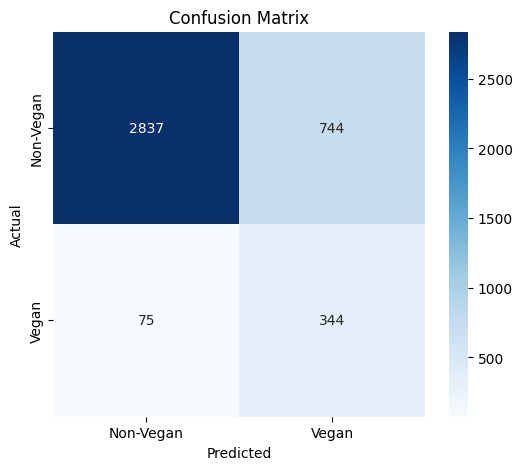

In [12]:
# Predict on the test set
log_y_pred = log_model.predict(X_test)

# Accuracy
log_acc = accuracy_score(y_test, log_y_pred)
print(f"Logistic Regression Accuracy: {log_acc:.4f}")

# Classification report
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, log_y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, log_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Support Vector Machine

In [13]:
# SVM
svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear')

Now, we evaluate the model.

SVM accuracy: 0.7930

Classification Report:
              precision    recall  f1-score   support

   Non-Vegan       0.98      0.79      0.87      3581
       Vegan       0.31      0.83      0.46       419

    accuracy                           0.79      4000
   macro avg       0.65      0.81      0.66      4000
weighted avg       0.91      0.79      0.83      4000



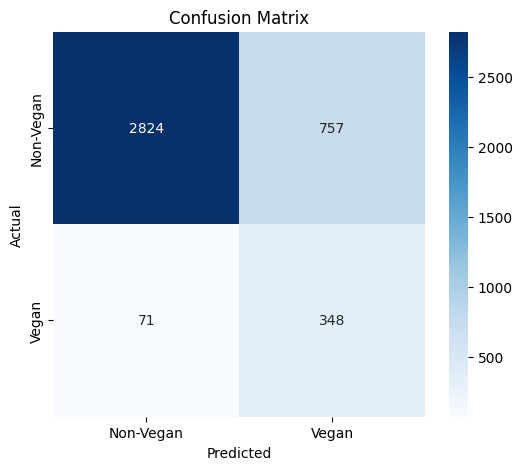

In [14]:
# Predict on the test set
SVM_y_pred = svm_model.predict(X_test)

# Accuracy
SVM_acc = accuracy_score(y_test, SVM_y_pred)
print(f"SVM accuracy: {SVM_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, SVM_y_pred, target_names=["Non-Vegan", "Vegan"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, SVM_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Although overall accuracy in both logistic regression and SVM is nearly 80%, the models struggle with precision on the vegan class. This indicates many false positives—non-vegan ingredients incorrectly predicted as vegan—which could be problematic depending on the application. 

This is a consequence of an highly umbalance dataset. So, we can try to balance the dataset manually.

In [15]:
# Balance the dataset by undersampling the majority class 
y = df['is_vegan'].values
X_vegan = w2v_tfidf_vectors[y == 1]
X_non_vegan = w2v_tfidf_vectors[y == 0]
y_vegan = y[y == 1]
y_non_vegan = y[y == 0]

# Determine the smaller class size
min_samples = min(len(X_vegan), len(X_non_vegan))

# Subsample both classes to ensure a 50/50 balance
X_vegan_balanced = X_vegan[:min_samples]
y_vegan_balanced = y_vegan[:min_samples]

X_non_vegan_balanced = X_non_vegan[:min_samples]
y_non_vegan_balanced = y_non_vegan[:min_samples]

# Concatenate the balanced dataset
X_balanced = np.vstack((X_vegan_balanced, X_non_vegan_balanced))
y_balanced = np.hstack((y_vegan_balanced, y_non_vegan_balanced))

# Shuffle the dataset
shuffled_indices = np.random.permutation(len(y_balanced))
X_balanced = X_balanced[shuffled_indices]
y_balanced = y_balanced[shuffled_indices]

print(f"Balanced dataset shape: {X_balanced.shape}")
print(f"Class distribution after balancing: {np.bincount(y_balanced)}")

Balanced dataset shape: (4352, 50)
Class distribution after balancing: [2176 2176]


In [16]:
# 80/20 split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Check class distribution in train and test sets
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Class distribution in training set: [1739 1742]
Class distribution in test set: [437 434]


Logistic Regression Accuracy: 0.8014

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80       437
           1       0.79      0.83      0.81       434

    accuracy                           0.80       871
   macro avg       0.80      0.80      0.80       871
weighted avg       0.80      0.80      0.80       871



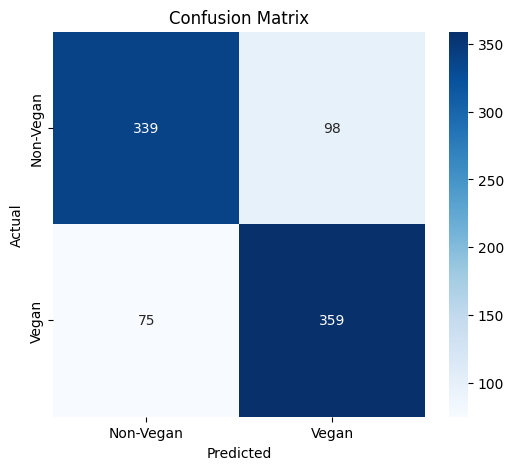

In [17]:
# Logistic Regression
log_model = LogisticRegression(C=1.0, max_iter=1000)
log_model.fit(X_train, y_train)

# Predict on the test set
log_y_pred = log_model.predict(X_test)

# Accuracy
log_acc = accuracy_score(y_test, log_y_pred)
print(f"Logistic Regression Accuracy: {log_acc:.4f}")

# Classification report
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, log_y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, log_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

SVM accuracy: 0.7991

Classification Report:
              precision    recall  f1-score   support

   Non-Vegan       0.82      0.77      0.79       437
       Vegan       0.78      0.83      0.80       434

    accuracy                           0.80       871
   macro avg       0.80      0.80      0.80       871
weighted avg       0.80      0.80      0.80       871



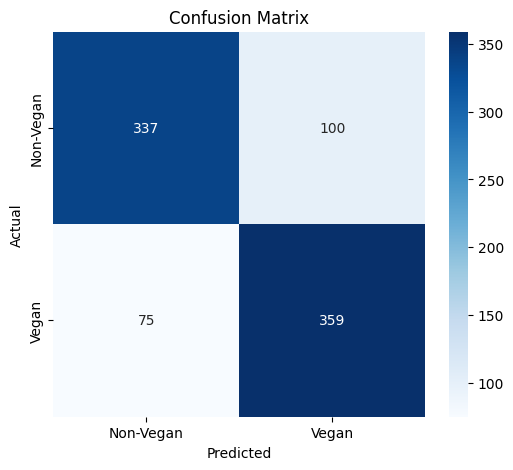

In [18]:
# SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict on the test set
SVM_y_pred = svm_model.predict(X_test)

# Accuracy
SVM_acc = accuracy_score(y_test, SVM_y_pred)
print(f"SVM accuracy: {SVM_acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, SVM_y_pred, target_names=["Non-Vegan", "Vegan"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, SVM_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

With a balanced dataset, both models perform good with an overall accuracy of 90%. 

### LSTM model

In [19]:
# Prepare text sequences from tokenized ingredients
texts = [" ".join(tokens) for tokens in tokenized_ingredients]

# Tokenize and convert to sequences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = max(len(seq) for seq in sequences)
X_seq = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [20]:
# Prepare the dataset
y = df['is_vegan'].values
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

In [21]:
# Load GloVe embeddings
glove_path = "/kaggle/input/glove6b100dtxt/glove.6B.100d.txt"  

embedding_dim = 100

# Load GloVe vectors into a dict
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

Loaded 400000 word vectors from GloVe.


In [22]:
# Prepare embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

In [24]:
# LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim,
              weights=[embedding_matrix], input_length=max_len, trainable=True),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')

])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.build(input_shape=(None, max_len))
lstm_model.summary()

history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1747734536.968148      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 283, 100)            │         848,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 933,009 (3.56 MB)

 Trainable params: 933,009 (3.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1747734542.672912     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


400/400 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.7709 - loss: 0.5008 - val_accuracy: 0.8763 - val_loss: 0.2935
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8976 - loss: 0.2605 - val_accuracy: 0.8703 - val_loss: 0.2815
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9244 - loss: 0.1862 - val_accuracy: 0.8591 - val_loss: 0.3565
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9429 - loss: 0.1401 - val_accuracy: 0.9197 - val_loss: 0.2399
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9591 - loss: 0.1058 - val_accuracy: 0.9397 - val_loss: 0.1537
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9683 - loss: 0.0779 - val_accuracy: 0.9316 - val_loss: 0.1939
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9693 - loss: 0.0687 - val_accuracy: 0.9375 - val_loss: 0.1812
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.9774 - loss: 0.0550 - val_accurac

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
LSTM Model Accuracy: 0.9370

LSTM Model Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      3581
           1       0.66      0.82      0.73       419

    accuracy                           0.94      4000
   macro avg       0.82      0.89      0.85      4000
weighted avg       0.95      0.94      0.94      4000



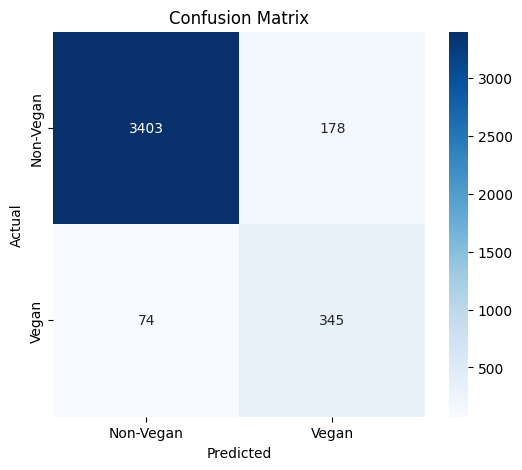

In [25]:
# Predict on the test set
lstm_y_prob = lstm_model.predict(X_test).flatten()
lstm_y_pred = (lstm_y_prob >= 0.5).astype(int)

# Accuracy
lstm_acc = accuracy_score(y_test, lstm_y_pred)
print(f"LSTM Model Accuracy: {lstm_acc:.4f}")

# Classification report
print("\nLSTM Model Classification Report:\n", classification_report(y_test, lstm_y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, lstm_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Vegan", "Vegan"], yticklabels=["Non-Vegan", "Vegan"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()